# group channels based on their decoding accuracy

In [1]:

from functions import  load_decoding_results, selective_channels, visual_pid_eid_pairs, define_bad_channels, get_epoch_StimOn, get_channels, get_behavior

visual_pid_eid_pair = visual_pid_eid_pairs(output_file='pid_eid_pairs.json', only_passive= True)
results = load_decoding_results(visual_pid_eid_pair, 'visual_mua_TrainPassiveTestActive' , dir = '/mnt/data/AdaptiveControl/mohammad/crnl/ibl_oscillations/_analyses/Decoding_spikes/results/rightVsLeft' )
right_selective, left_selective, right_sensitive, left_sensitive, neutral = selective_channels(results)
print('Right selective: ', len(right_selective))
print('Left selective: ', len(left_selective))

Total number of probe insertions: 205
Number of sessions without passive data: 76
Number of sessions with passive data: 129
PID-EID pairs saved to pid_eid_pairs.json
Number of missing pids: 11
 number of total channnels 3948
Right selective:  58
Left selective:  59


In [2]:
visuals = ['VISp', 'VISpm', 'VISam', 'VISa', 'VISrl', 'VISal', 'VISli', 'VISl']
import re 
RS_ch = right_selective['acronyms']
LS_ch = left_selective['acronyms']
for region in visuals:
    print(region, len([ch for ch in RS_ch if re.match(rf'^{region}[12456]', ch)]))
    print(region, len([ch for ch in LS_ch if re.match(rf'^{region}[12456]', ch)]))

VISp 14
VISp 19
VISpm 8
VISpm 7
VISam 7
VISam 9
VISa 21
VISa 18
VISrl 2
VISrl 1
VISal 1
VISal 3
VISli 3
VISli 1
VISl 2
VISl 1


In [3]:
# concat two dataframes
import pandas as pd
import numpy as np  
from functions import get_TFR
import submitit
cpus = 10

def submit_get_TFR(pid):
    ch_index = selectives.loc[selectives['pid'] == pid, 'ch_indexs'].tolist()
    eid = [eid for p, eid in visual_pid_eid_pair if p == pid][0]
    pid_TFR = get_TFR(pid, ch_index, eid, n_jobs = cpus, condition = 'Right_Left', tmin = -0.5, tmax = 1 )
    return pid_TFR


selectives = pd.concat([right_selective, left_selective])
acronyms = selectives['acronyms']
keep_indx = [i for i, ch in enumerate(acronyms) if re.match(rf'^VISp[12456]', ch) or re.match(rf'^VISa[12456]', ch)  ]
selectives = selectives[~selectives['ch_indexs'].isin([0, 383])].iloc[keep_indx]
pids = np.unique(selectives['pid'].values)

executor = submitit.AutoExecutor(folder='logs')
executor.update_parameters(slurm_array_parallelism= 50 , mem_gb=20, timeout_min= 120, slurm_partition= 'CPU',  cpus_per_task= cpus)
# Submit all jobs using map_array                                                                                              
all_jobs = executor.map_array(submit_get_TFR, pids)
# get the results

    

In [23]:
right_TF_all = []
left_TF_all = []
diff_TF_all = []
df_all = []
for i, pid in enumerate(pids):
    try:
        df = selectives.loc[selectives['pid'] == pid]
        acronyms = df['acronyms'].tolist()
        ch_index = df['ch_indexs'].tolist()
        if len(ch_index) == 0:
            continue
        right_TF , left_TF = all_jobs[i].result()
        right_TF = right_TF.crop(tmin = -0.3, tmax = 0.8)
        left_TF = left_TF.crop(tmin = -0.3, tmax = 0.8)
        # log1 = np.log(right_TF.data)
        # log2 = np.log(left_TF.data)
        # diff = log1 - log2
        averageTFR_1_bsline_corrected = right_TF.copy().apply_baseline(mode='percent', baseline=(None, None))
        averageTFR_2_bsline_corrected = left_TF.copy().apply_baseline(mode='percent', baseline=(None, None))
        data_right = averageTFR_1_bsline_corrected.data
        data_left = averageTFR_2_bsline_corrected.data
        diff = data_right - data_left
        right_TF_all.append(data_right)
        left_TF_all.append(data_left)
        diff_TF_all.append(diff)
        df_all.append(df)
    except Exception as e:
        continue
right_TF_all = np.concatenate(right_TF_all, axis = 0)
left_TF_all = np.concatenate(left_TF_all, axis = 0)
diff_TF_all = np.concatenate(diff_TF_all, axis = 0)
# concatenate all the dataframes
df_all = pd.concat(df_all)
df_all['index'] = np.arange(len(df_all))
times = right_TF.times
freqs = right_TF.freqs

Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying b

In [28]:
# save the data
np.save('right_TF_all.npy', right_TF_all)
np.save('left_TF_all.npy', left_TF_all)
np.save('diff_TF_all.npy', diff_TF_all)
import pickle
with open('df_all.pkl', 'wb') as f:
    pickle.dump(df_all, f)

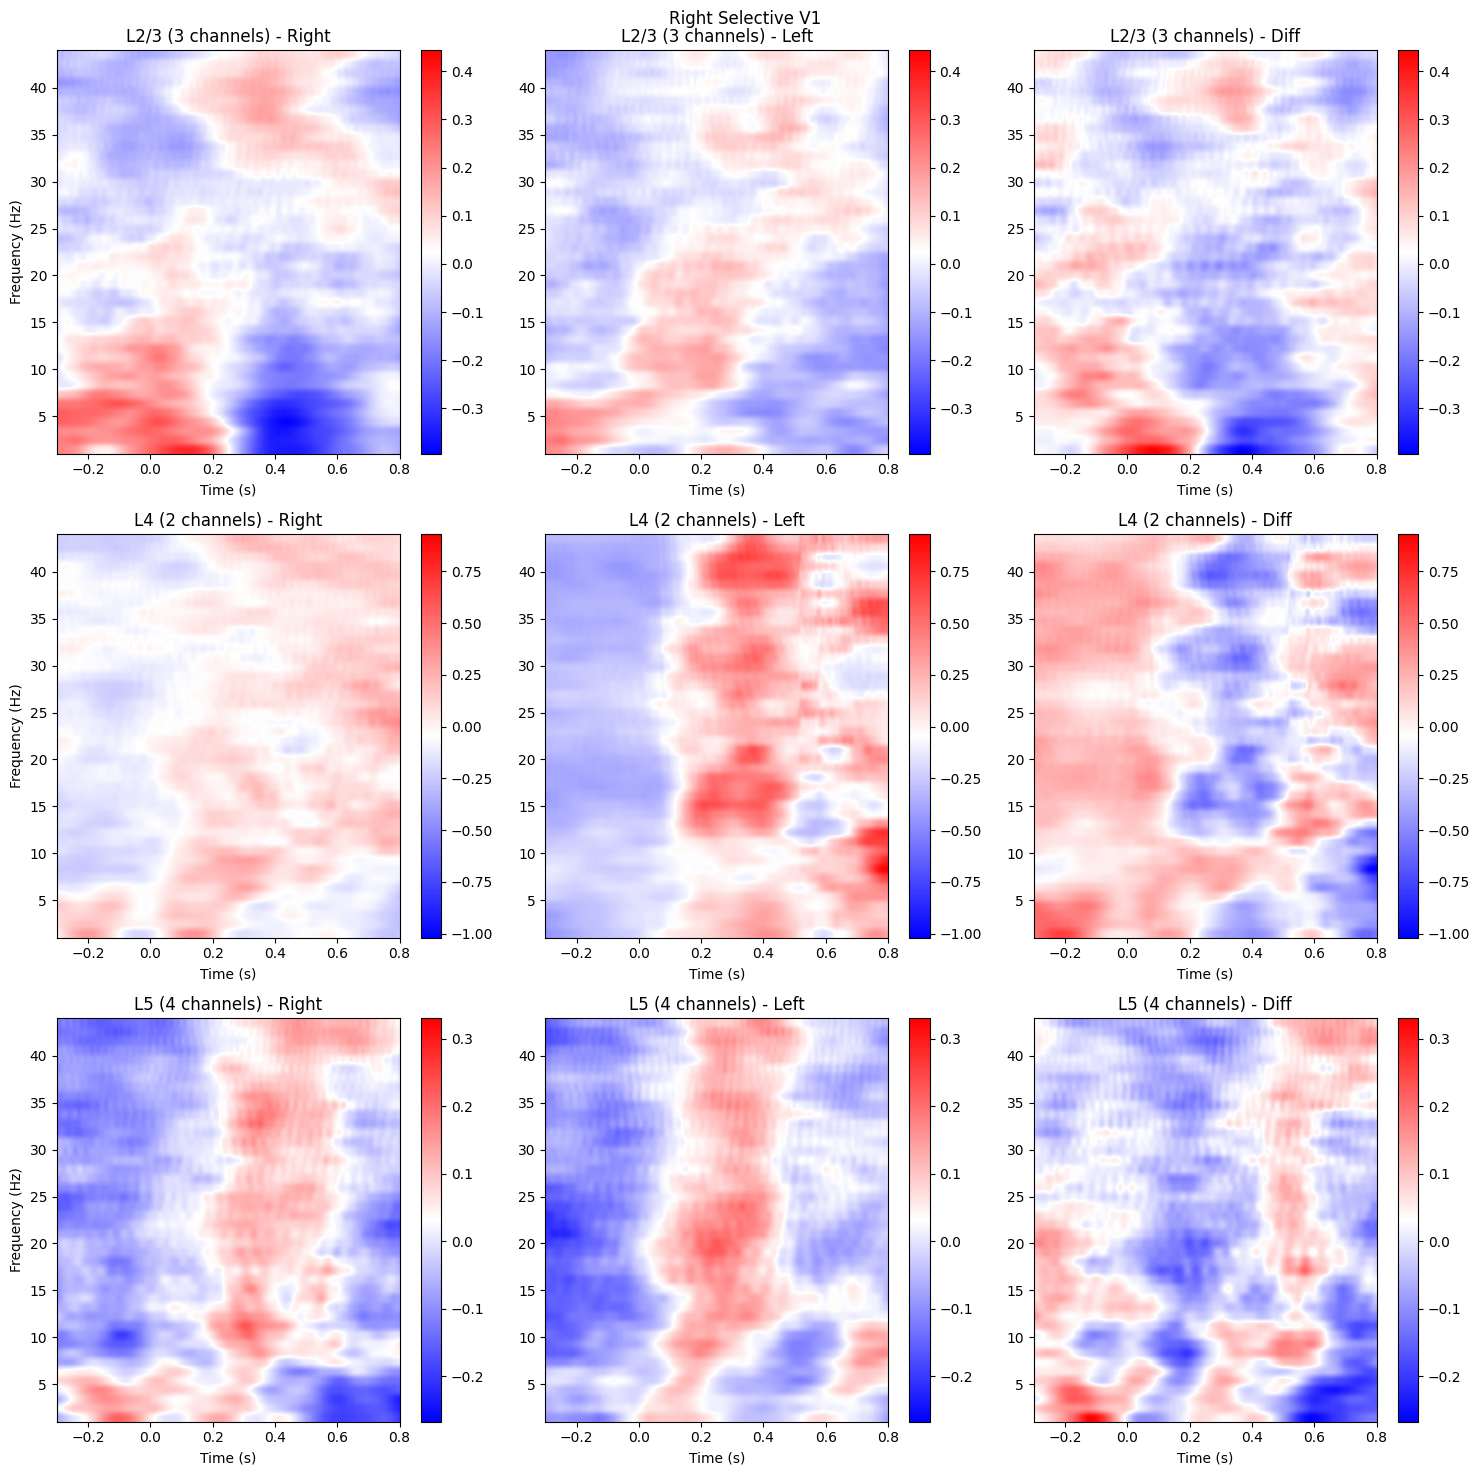

In [45]:
p_value_threshold = 0.05
accuracy_threshold = 0.5

# Filter selective channels
c1_sensitive = df_all.query('p_value_c1 < @p_value_threshold and accuracies_c1 > @accuracy_threshold')
c2_sensitive = df_all.query('p_value_c2 < @p_value_threshold and accuracies_c2 > @accuracy_threshold')

right_selective = c1_sensitive.query('p_value_c2 > @p_value_threshold or accuracies_c2 < @accuracy_threshold')
left_selective = c2_sensitive.query('p_value_c1 > @p_value_threshold or accuracies_c1 < @accuracy_threshold')

# Mapping layers
layers_map = {
    'L1': 'VISp1',
    'L2/3': 'VISp2/3',
    'L4': 'VISp4',
    'L5': 'VISp5',
    'L6': 'VISp6'
}

# Extract indices and compute averages
right_data, left_data, diff_data, channel_counts = [], [], [], []
for layer, acronym in layers_map.items():
    indices = right_selective.loc[right_selective['acronyms'] == acronym, 'index'].values
    if indices.size > 0:  # Skip layers with no channels
        right_data.append(np.mean(right_TF_all[indices], axis=0))
        left_data.append(np.mean(left_TF_all[indices], axis=0))
        diff_data.append(np.mean(diff_TF_all[indices], axis=0))
        channel_counts.append(indices.size)  # Store the number of channels
    else:
        right_data.append(np.array([]))
        left_data.append(np.array([]))
        diff_data.append(np.array([]))
        channel_counts.append(0)

# Filter out empty layers
valid_layers = [
    (layer, right, left, diff, count)
    for (layer, right, left, diff, count) in zip(layers_map.keys(), right_data, left_data, diff_data, channel_counts)
    if right.size > 0 and left.size > 0 and diff.size > 0
]

# Plot valid layers
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(valid_layers), 3, figsize=(15, len(valid_layers) * 5), squeeze=False)
fig.suptitle('Right Selective V1')

for i, (layer, right, left, diff, count) in enumerate(valid_layers):
    # min in right and left
    min_right = np.min(right)
    min_left = np.min(left)
    min_diff = np.min(diff)
    min_val = min(min_right, min_left, min_diff)
    # max in right and left
    max_right = np.max(right)
    max_left = np.max(left)
    max_diff = np.max(diff)
    max_val = max(max_right, max_left, max_diff)
    for j, (data, title) in enumerate(zip([right, left, diff], ['Right', 'Left', 'Diff'])):
        ax = axes[i, j]
        im = ax.imshow(data, aspect='auto', extent=[times[0], times[-1], freqs[0], freqs[-1]], vmin= min_val,vmax = max_val , origin='lower', cmap='bwr')
        ax.set_title(f'{layer} ({count} channels) - {title}')
        ax.set_xlabel('Time (s)')
        if j == 0:
            ax.set_ylabel('Frequency (Hz)')
        fig.colorbar(im, ax=ax, orientation='vertical')
plt.tight_layout()
plt.show()


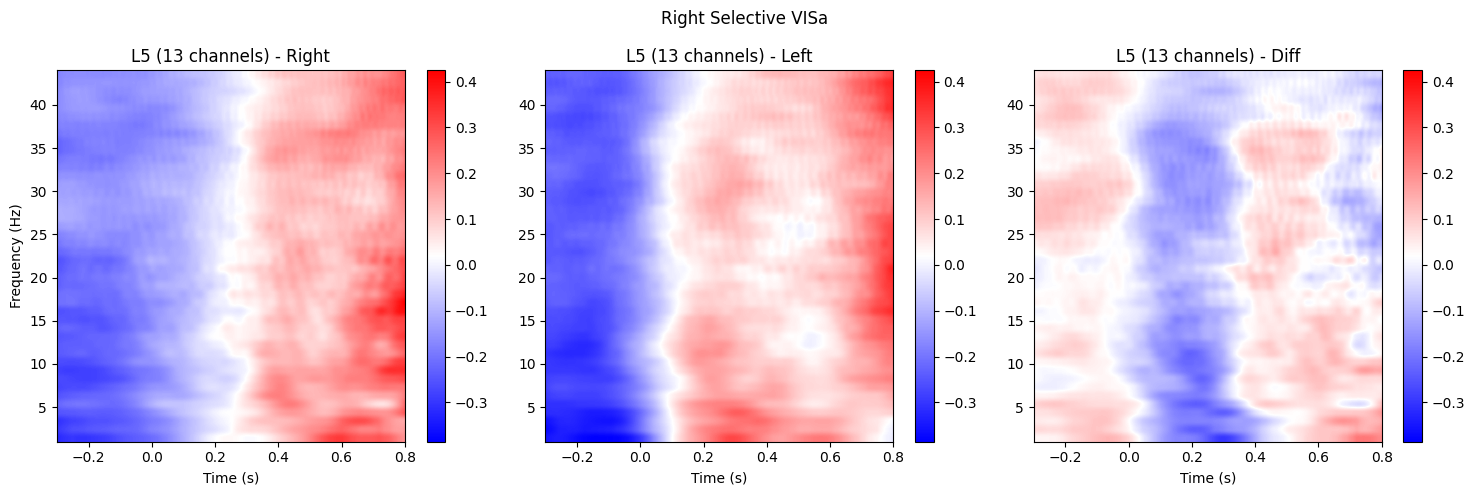

In [43]:
p_value_threshold = 0.05
accuracy_threshold = 0.5

# Filter selective channels
c1_sensitive = df_all.query('p_value_c1 < @p_value_threshold and accuracies_c1 > @accuracy_threshold')
c2_sensitive = df_all.query('p_value_c2 < @p_value_threshold and accuracies_c2 > @accuracy_threshold')

right_selective = c1_sensitive.query('p_value_c2 > @p_value_threshold or accuracies_c2 < @accuracy_threshold')
left_selective = c2_sensitive.query('p_value_c1 > @p_value_threshold or accuracies_c1 < @accuracy_threshold')

# Mapping layers
layers_map = {
    'L1': 'VISa1',
    'L2/3': 'VISa2/3',
    'L4': 'VISa4',
    'L5': 'VISa5',
    'L6': 'VISa6'
}

# Extract indices and compute averages
right_data, left_data, diff_data, channel_counts = [], [], [], []
for layer, acronym in layers_map.items():
    indices = right_selective.loc[right_selective['acronyms'] == acronym, 'index'].values
    if indices.size > 0:  # Skip layers with no channels
        right_data.append(np.mean(right_TF_all[indices], axis=0))
        left_data.append(np.mean(left_TF_all[indices], axis=0))
        diff_data.append(np.mean(diff_TF_all[indices], axis=0))
        channel_counts.append(indices.size)  # Store the number of channels
    else:
        right_data.append(np.array([]))
        left_data.append(np.array([]))
        diff_data.append(np.array([]))
        channel_counts.append(0)

# Filter out empty layers
valid_layers = [
    (layer, right, left, diff, count)
    for (layer, right, left, diff, count) in zip(layers_map.keys(), right_data, left_data, diff_data, channel_counts)
    if right.size > 0 and left.size > 0 and diff.size > 0
]

# Plot valid layers
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(valid_layers), 3, figsize=(15, len(valid_layers) * 5), squeeze=False)
fig.suptitle('Right Selective VISa')

for i, (layer, right, left, diff, count) in enumerate(valid_layers):
    # min in right and left
    min_right = np.min(right)
    min_left = np.min(left)
    min_diff = np.min(diff)
    min_val = min(min_right, min_left, min_diff)
    # max in right and left
    max_right = np.max(right)
    max_left = np.max(left)
    max_diff = np.max(diff)
    max_val = max(max_right, max_left, max_diff)
    for j, (data, title) in enumerate(zip([right, left, diff], ['Right', 'Left', 'Diff'])):
        ax = axes[i, j]
        im = ax.imshow(data, aspect='auto', extent=[times[0], times[-1], freqs[0], freqs[-1]], vmin= min_val,vmax = max_val , origin='lower', cmap='bwr')
        ax.set_title(f'{layer} ({count} channels) - {title}')
        ax.set_xlabel('Time (s)')
        if j == 0:
            ax.set_ylabel('Frequency (Hz)')
        fig.colorbar(im, ax=ax, orientation='vertical')
plt.tight_layout()
plt.show()


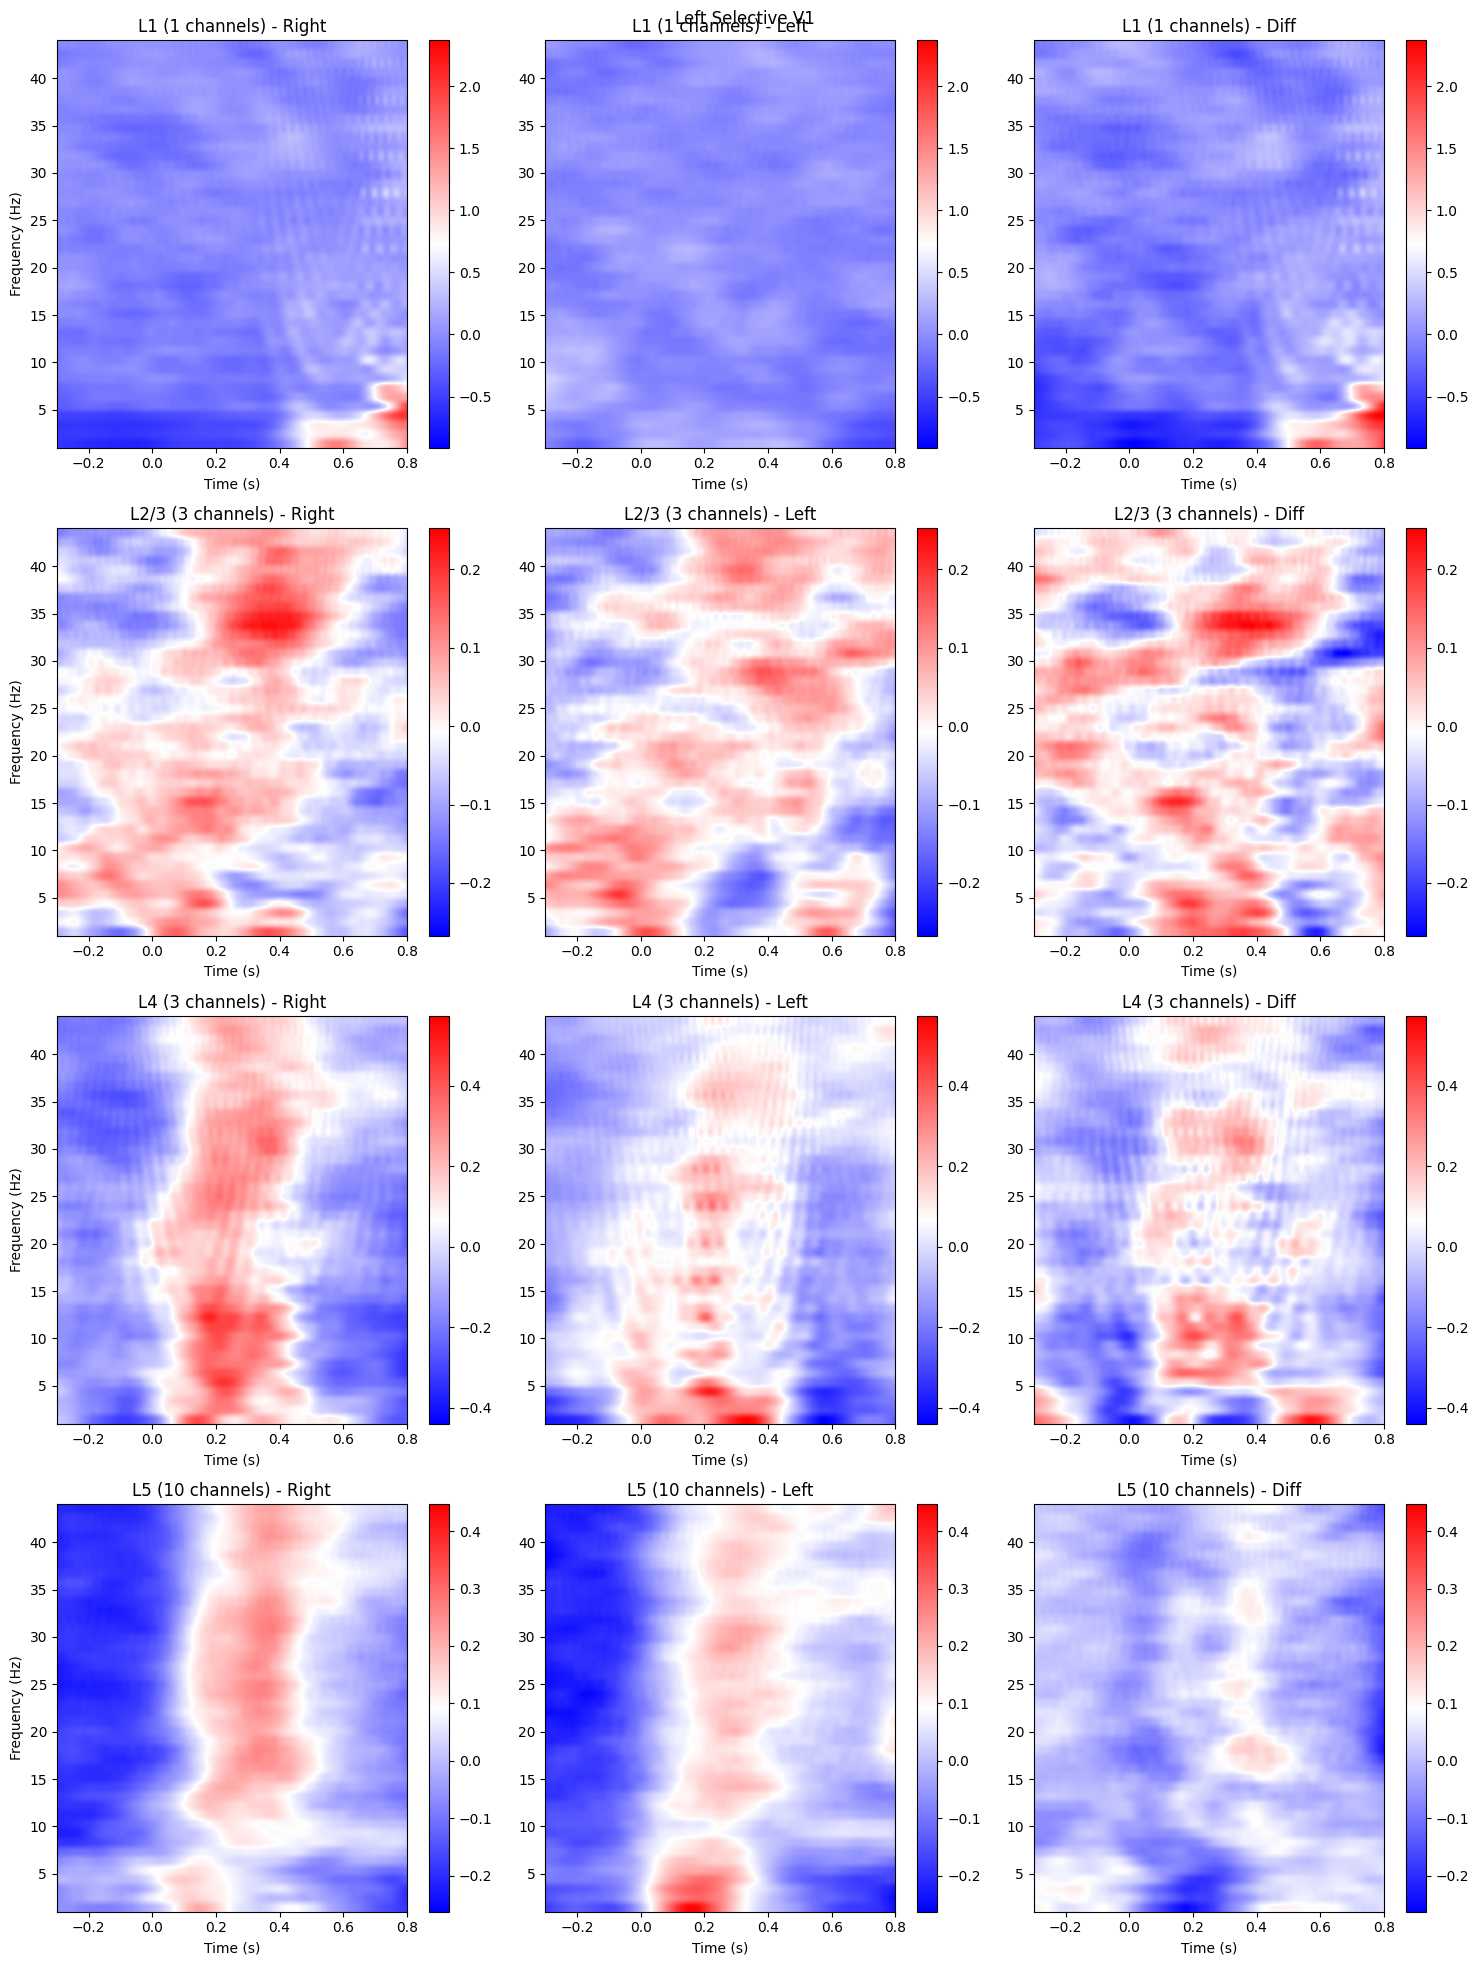

In [42]:
p_value_threshold = 0.05
accuracy_threshold = 0.5

# Filter selective channels
c1_sensitive = df_all.query('p_value_c1 < @p_value_threshold and accuracies_c1 > @accuracy_threshold')
c2_sensitive = df_all.query('p_value_c2 < @p_value_threshold and accuracies_c2 > @accuracy_threshold')

right_selective = c1_sensitive.query('p_value_c2 > @p_value_threshold or accuracies_c2 < @accuracy_threshold')
left_selective = c2_sensitive.query('p_value_c1 > @p_value_threshold or accuracies_c1 < @accuracy_threshold')

# Mapping layers
layers_map = {
    'L1': 'VISp1',
    'L2/3': 'VISp2/3',
    'L4': 'VISp4',
    'L5': 'VISp5',
    'L6': 'VISp6'
}

# Extract indices and compute averages
right_data, left_data, diff_data, channel_counts = [], [], [], []
for layer, acronym in layers_map.items():
    indices = left_selective.loc[left_selective['acronyms'] == acronym, 'index'].values
    if indices.size > 0:  # Skip layers with no channels
        right_data.append(np.mean(right_TF_all[indices], axis=0))
        left_data.append(np.mean(left_TF_all[indices], axis=0))
        diff_data.append(np.mean(diff_TF_all[indices], axis=0))
        channel_counts.append(indices.size)  # Store the number of channels
    else:
        right_data.append(np.array([]))
        left_data.append(np.array([]))
        diff_data.append(np.array([]))
        channel_counts.append(0)

# Filter out empty layers
valid_layers = [
    (layer, right, left, diff, count)
    for (layer, right, left, diff, count) in zip(layers_map.keys(), right_data, left_data, diff_data, channel_counts)
    if right.size > 0 and left.size > 0 and diff.size > 0
]

# Plot valid layers
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(valid_layers), 3, figsize=(15, len(valid_layers) * 5), squeeze=False)
fig.suptitle('Left Selective V1')
for i, (layer, right, left, diff, count) in enumerate(valid_layers):
    # min in right and left
    min_right = np.min(right)
    min_left = np.min(left)
    min_diff = np.min(diff)
    min_val = min(min_right, min_left, min_diff)
    # max in right and left
    max_right = np.max(right)
    max_left = np.max(left)
    max_diff = np.max(diff)
    max_val = max(max_right, max_left, max_diff)
    for j, (data, title) in enumerate(zip([right, left, diff], ['Right', 'Left', 'Diff'])):
        ax = axes[i, j]
        im = ax.imshow(data, aspect='auto', extent=[times[0], times[-1], freqs[0], freqs[-1]], vmin= min_val,vmax = max_val , origin='lower', cmap='bwr')
        ax.set_title(f'{layer} ({count} channels) - {title}')
        ax.set_xlabel('Time (s)')
        if j == 0:
            ax.set_ylabel('Frequency (Hz)')
        fig.colorbar(im, ax=ax, orientation='vertical')
plt.tight_layout()
plt.show()


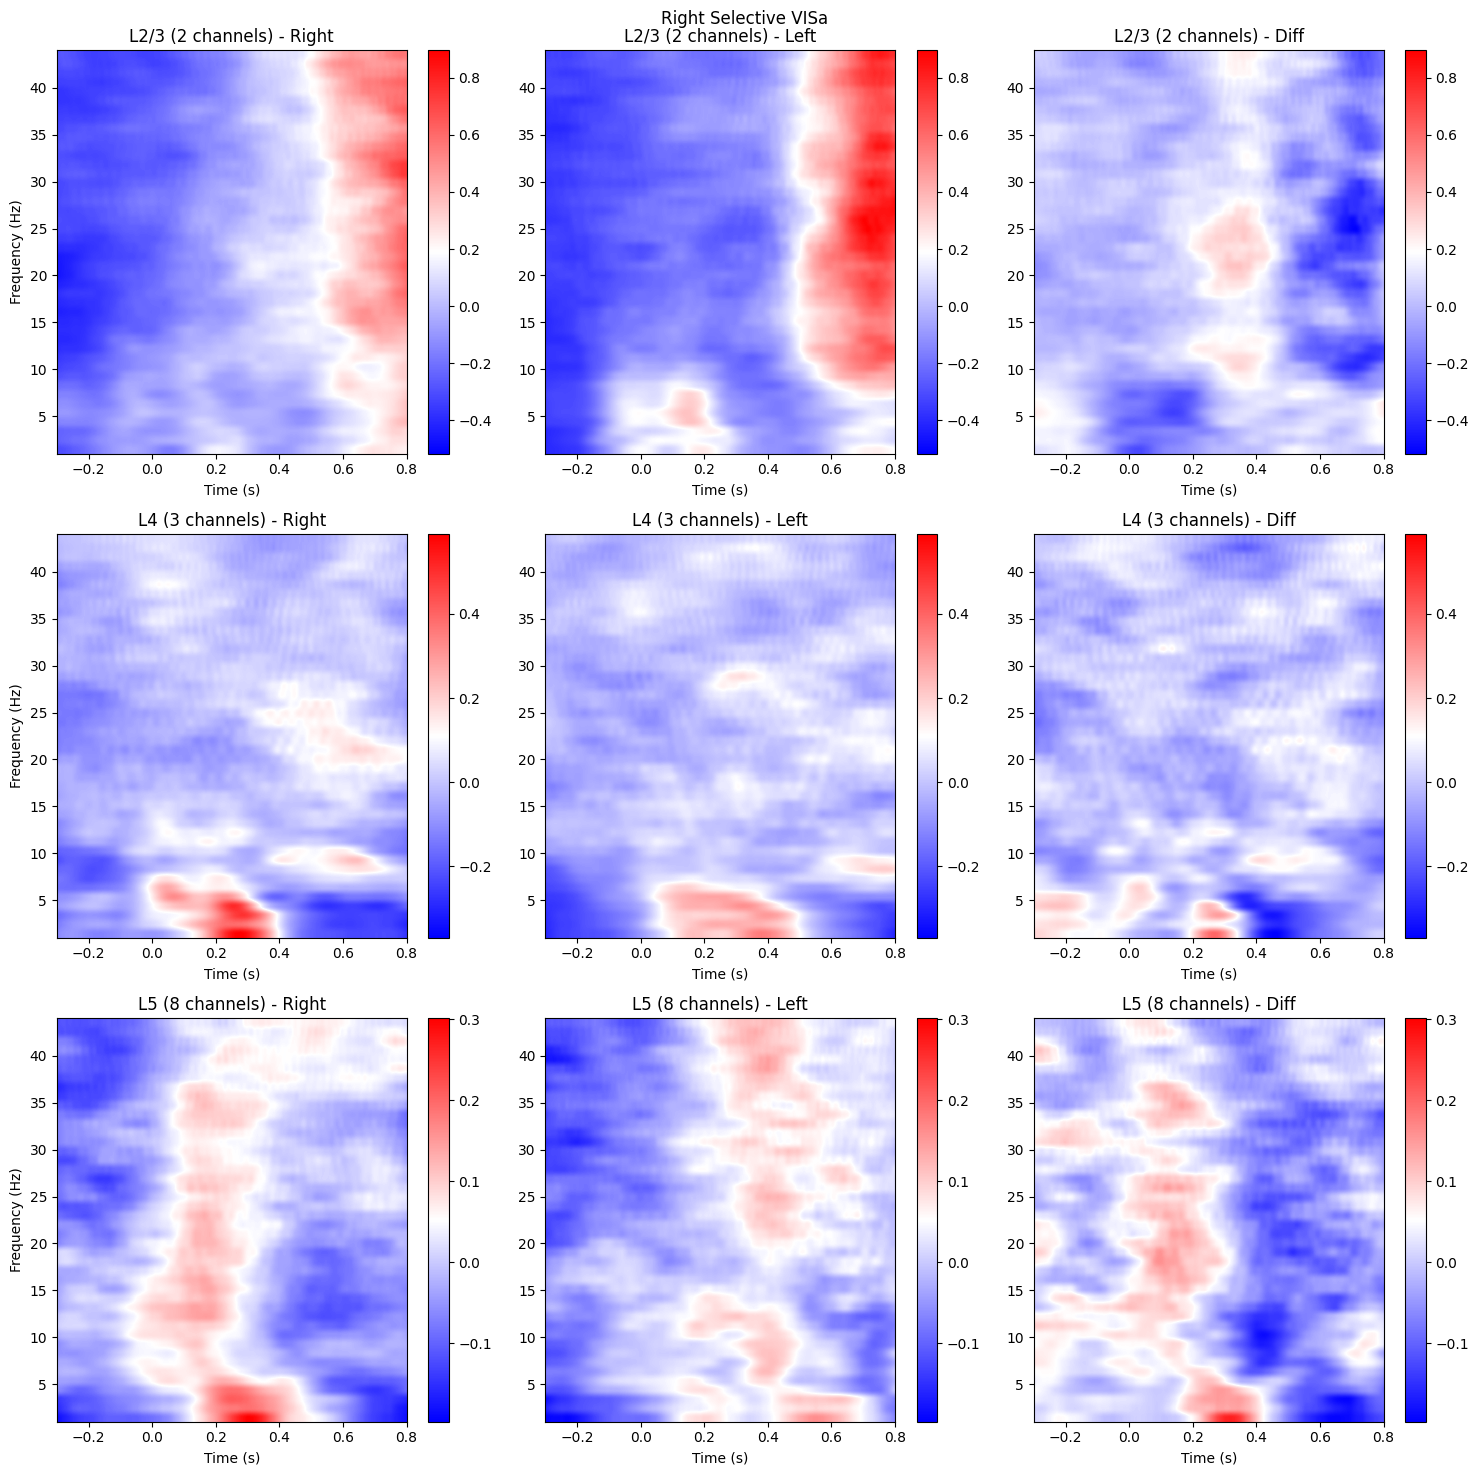

In [44]:
p_value_threshold = 0.05
accuracy_threshold = 0.5

# Filter selective channels
c1_sensitive = df_all.query('p_value_c1 < @p_value_threshold and accuracies_c1 > @accuracy_threshold')
c2_sensitive = df_all.query('p_value_c2 < @p_value_threshold and accuracies_c2 > @accuracy_threshold')

right_selective = c1_sensitive.query('p_value_c2 > @p_value_threshold or accuracies_c2 < @accuracy_threshold')
left_selective = c2_sensitive.query('p_value_c1 > @p_value_threshold or accuracies_c1 < @accuracy_threshold')

# Mapping layers
layers_map = {
    'L1': 'VISa1',
    'L2/3': 'VISa2/3',
    'L4': 'VISa4',
    'L5': 'VISa5',
    'L6': 'VISa6'
}

# Extract indices and compute averages
right_data, left_data, diff_data, channel_counts = [], [], [], []
for layer, acronym in layers_map.items():
    indices = left_selective.loc[left_selective['acronyms'] == acronym, 'index'].values
    if indices.size > 0:  # Skip layers with no channels
        right_data.append(np.mean(right_TF_all[indices], axis=0))
        left_data.append(np.mean(left_TF_all[indices], axis=0))
        diff_data.append(np.mean(diff_TF_all[indices], axis=0))
        channel_counts.append(indices.size)  # Store the number of channels
    else:
        right_data.append(np.array([]))
        left_data.append(np.array([]))
        diff_data.append(np.array([]))
        channel_counts.append(0)

# Filter out empty layers
valid_layers = [
    (layer, right, left, diff, count)
    for (layer, right, left, diff, count) in zip(layers_map.keys(), right_data, left_data, diff_data, channel_counts)
    if right.size > 0 and left.size > 0 and diff.size > 0
]

# Plot valid layers
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(valid_layers), 3, figsize=(15, len(valid_layers) * 5), squeeze=False)
fig.suptitle('Right Selective VISa')

for i, (layer, right, left, diff, count) in enumerate(valid_layers):
    # min in right and left
    min_right = np.min(right)
    min_left = np.min(left)
    min_diff = np.min(diff)
    min_val = min(min_right, min_left, min_diff)
    # max in right and left
    max_right = np.max(right)
    max_left = np.max(left)
    max_diff = np.max(diff)
    max_val = max(max_right, max_left, max_diff)
    for j, (data, title) in enumerate(zip([right, left, diff], ['Right', 'Left', 'Diff'])):
        ax = axes[i, j]
        im = ax.imshow(data, aspect='auto', extent=[times[0], times[-1], freqs[0], freqs[-1]], vmin= min_val,vmax = max_val , origin='lower', cmap='bwr')
        ax.set_title(f'{layer} ({count} channels) - {title}')
        ax.set_xlabel('Time (s)')
        if j == 0:
            ax.set_ylabel('Frequency (Hz)')
        fig.colorbar(im, ax=ax, orientation='vertical')
plt.tight_layout()
plt.show()